# Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function

This is done with the `MCsampler` that uses the Saltelli algorithm [1] to compute the Sobol indices. If `n_mc_samples` is the number of Monte Carlo samples specified in the `MCSampler`, the Saltelli algorithm uses `n_mc_samples * (d + 2)` samples to compute the Sobol indices, where `d` is the number of random input variables. Bootstrapping is used to compute confidence intervals on the Sobol index estimates. 

[1] A. Saltelli, *Making best use of model evaluations to compute sensitivity indices*, Computer Physics Communications, 2002.

In [1]:
# Run an EasyVVUQ campaign to analyze tgohe sensitivity for the Ishigami function
# This is done with SC.
import os
import easyvvuq as uq
import chaospy as cp
import pickle
import numpy as np
import matplotlib.pylab as plt
import time
import pandas as pd
from collections import OrderedDict

In [2]:
np.__version__

'1.26.4'

In [3]:
# Define the Ishigami function
def ishigamiSA(a,b):
    '''Exact sensitivity indices of the Ishigami function for given a and b.
    From https://openturns.github.io/openturns/master/examples/meta_modeling/chaos_ishigami.html
    '''
    var = 1.0/2 + a**2/8 + b*np.pi**4/5 + b**2*np.pi**8/18
    S1 = (1.0/2 + b*np.pi**4/5+b**2*np.pi**8/50)/var
    S2 = (a**2/8)/var
    S3 = 0
    S13 = b**2*np.pi**8/2*(1.0/9-1.0/25)/var
    exact = {
            'expectation' : a/2,
            'variance' : var,
            'S1' : (1.0/2 + b*np.pi**4/5+b**2*np.pi**8.0/50)/var,
            'S2' : (a**2/8)/var,
            'S3' : 0,
            'S12' : 0,
            'S23' : 0,
            'S13' : S13,
            'S123' : 0,
            'ST1' : S1 + S13,
            'ST2' : S2,
            'ST3' : S3 + S13
            }
    return exact

Ishigami_a = 7.0
Ishigami_b = 0.1
exact = ishigamiSA(Ishigami_a, Ishigami_b)

In [4]:
# define a model to run the Ishigami code directly from python, expecting a dictionary and returning a dictionary
def run_ishigami_model(input):
    import Ishigami
    qois = ["Ishigami"]
    del input['out_file']
    return {qois[0]: Ishigami.evaluate(**input)}

In [5]:
# Define parameter space
def define_params():
    return {
        "x1":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x2":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x3":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "a":        {"type": "float",   "min": Ishigami_a, "max": Ishigami_a, "default": Ishigami_a},
        "b":        {"type": "float",   "min": Ishigami_b, "max": Ishigami_b, "default": Ishigami_b},
        "out_file": {"type": "string",  "default": "output.csv"}
    }

In [6]:
# Define parameter space
def define_vary():
    return {
        "x1":   cp.Uniform(-np.pi, np.pi),
        "x2":   cp.Uniform(-np.pi, np.pi),
        "x3":   cp.Uniform(-np.pi, np.pi)
    }

In [7]:
# Set up and run a campaign
def run_campaign(n_mc_samples, use_files=False):

    times = np.zeros(7)

    time_start = time.time()
    time_start_whole = time_start

    work_dir = '/tmp'
    
    # Set up a fresh campaign called "Ishigami_sc."
    my_campaign = uq.Campaign(name='Ishigami_mc.', work_dir=work_dir)

    # Create an encoder and decoder for SC test app
    if use_files:
        encoder = uq.encoders.GenericEncoder(template_fname='Ishigami.template',
                                             delimiter='$',
                                             target_filename='Ishigami_in.json')

        decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                                        output_columns=["Ishigami"])

        execute = uq.actions.ExecuteLocal('python3 %s/Ishigami.py Ishigami_in.json' % (os.getcwd()))

        actions = uq.actions.Actions(uq.actions.CreateRunDirectory(work_dir), 
                          uq.actions.Encode(encoder), execute, uq.actions.Decode(decoder))
    else:
        actions = uq.actions.Actions(uq.actions.ExecutePython(run_ishigami_model))

    # Add the app (automatically set as current app)
    my_campaign.add_app(name="Ishigami", params=define_params(), actions=actions)

    # Create the sampler
    time_end = time.time()
    times[1] = time_end-time_start
    print('Time for phase 1 = %.3f' % (times[1]))

    time_start = time.time()
    # Associate a sampler with the campaign
    # Latin HyperCube
    sampler = uq.sampling.MCSampler(vary=define_vary(), n_mc_samples=n_mc_samples, rule='sobol')
    # QMC method with Sobol sequence
    #sampler = uq.sampling.QMCSampler(vary=define_vary(), n_mc_samples=n_mc_samples)
    my_campaign.set_sampler(sampler)

    # Will draw all (of the finite set of samples)
    my_campaign.draw_samples()
    print('Number of samples = %s' % my_campaign.get_active_sampler().count)

    time_end = time.time()
    times[2] = time_end-time_start
    print('Time for phase 2 = %.3f' % (times[2]))

    time_start = time.time()
    # Run the cases
    my_campaign.execute(sequential=True).collate(progress_bar=True)

    time_end = time.time()
    times[3] = time_end-time_start
    print('Time for phase 3 = %.3f' % (times[3]))

    time_start = time.time()
    # Get the results
    results_df = my_campaign.get_collation_result()

    time_end = time.time()
    times[4] = time_end-time_start
    print('Time for phase 4 = %.3f' % (times[4]))

    time_start = time.time()
    # Post-processing analysis
    results = my_campaign.analyse(qoi_cols=["Ishigami"])
        
    time_end = time.time()
    times[5] = time_end-time_start
    print('Time for phase 5 = %.3f' % (times[5]))

    time_start = time.time()
    # Save the results
    #pickle.dump(results, open('Ishigami_results.pickle','bw'))
    time_end = time.time()
    times[6] = time_end-time_start
    print('Time for phase 6 = %.3f' % (times[6]))
#
    times[0] = time_end - time_start_whole

    return results_df, results, times, n_mc_samples, my_campaign.get_active_sampler().count

In [8]:
# Calculate the results for a range of MC points

d = len(define_vary())

R = {}
for n_mc_samples in [100, 500, 1000, 2000, 5000, 8000, 10000]:
    # the true number of MC samples used by Saltelli's algorithm
    n = n_mc_samples * (d + 2)
    R[n] = {}
    (R[n]['results_df'], 
     R[n]['results'], 
     R[n]['times'], 
     R[n]['order'], 
     R[n]['number_of_samples']) = run_campaign(n_mc_samples=n_mc_samples, use_files=False)

Time for phase 1 = 0.041
Number of samples = 500
Time for phase 2 = 0.287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1705.82it/s]


Time for phase 3 = 0.331
Time for phase 4 = 0.018
Vectorized bootstrapping
Vectorized bootstrapping
Vectorized bootstrapping
Time for phase 5 = 0.584
Time for phase 6 = 0.000
Time for phase 1 = 0.014
Number of samples = 2500
Time for phase 2 = 1.331


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1749.57it/s]


Time for phase 3 = 1.560
Time for phase 4 = 0.060
Vectorized bootstrapping
Vectorized bootstrapping
Vectorized bootstrapping
Time for phase 5 = 2.617
Time for phase 6 = 0.000
Time for phase 1 = 0.014
Number of samples = 5000
Time for phase 2 = 2.585


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1790.71it/s]


Time for phase 3 = 3.055
Time for phase 4 = 0.218
Vectorized bootstrapping
Vectorized bootstrapping
Vectorized bootstrapping
Time for phase 5 = 4.946
Time for phase 6 = 0.000
Time for phase 1 = 0.013
Number of samples = 10000
Time for phase 2 = 4.889


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1790.35it/s]


Time for phase 3 = 6.317
Time for phase 4 = 0.225
Vectorized bootstrapping
Vectorized bootstrapping
Vectorized bootstrapping
Time for phase 5 = 10.093
Time for phase 6 = 0.000
Time for phase 1 = 0.013
Number of samples = 25000
Time for phase 2 = 12.269


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:14<00:00, 1709.99it/s]


Time for phase 3 = 16.129
Time for phase 4 = 0.788
Vectorized bootstrapping
Vectorized bootstrapping
Vectorized bootstrapping
Time for phase 5 = 24.465
Time for phase 6 = 0.000
Time for phase 1 = 0.015
Number of samples = 40000
Time for phase 2 = 19.727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [00:24<00:00, 1633.65it/s]


Time for phase 3 = 26.909
Time for phase 4 = 1.404
Vectorized bootstrapping
Vectorized bootstrapping
Vectorized bootstrapping
Time for phase 5 = 41.627
Time for phase 6 = 0.000
Time for phase 1 = 0.014
Number of samples = 50000
Time for phase 2 = 24.701


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:31<00:00, 1598.77it/s]


Time for phase 3 = 34.277
Time for phase 4 = 1.542
Vectorized bootstrapping
Vectorized bootstrapping
Vectorized bootstrapping
Time for phase 5 = 52.721
Time for phase 6 = 0.000


In [9]:
# produce a table of the time taken for various phases
# the phases are:
#   1: creation of campaign
#   2: creation of samples
#   3: running the cases
#   4: calculation of statistics including Sobols
#   5: returning of analysed results
#   6: saving campaign and pickled results

Timings = pd.DataFrame(np.array([R[r]['times'] for r in list(R.keys())]), 
             columns=['Total', 'Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 5', 'Phase 6'], 
             index=[R[r]['order'] for r in list(R.keys())])
# Timings.to_csv(open('Timings.csv', 'w'))
display(Timings)

,Total,Phase 1,Phase 2,Phase 3,Phase 4,Phase 5,Phase 6
100,1.260757,0.040516,0.286757,0.331316,0.018250,0.583718,0.000000e+00
500,5.582315,0.013734,1.331474,1.559944,0.059944,2.617055,0.000000e+00
1000,10.818045,0.014133,2.584934,3.054697,0.218218,4.945894,2.384186e-07
2000,21.537552,0.013226,4.889090,6.317368,0.224951,10.092670,2.384186e-07
5000,53.663493,0.013134,12.268547,16.128820,0.787628,24.465055,2.384186e-07
8000,89.682246,0.014748,19.727481,26.908590,1.403926,41.627187,2.384186e-07
10000,113.255918,0.014273,24.701281,34.277065,1.542012,52.721014,0.000000e+00


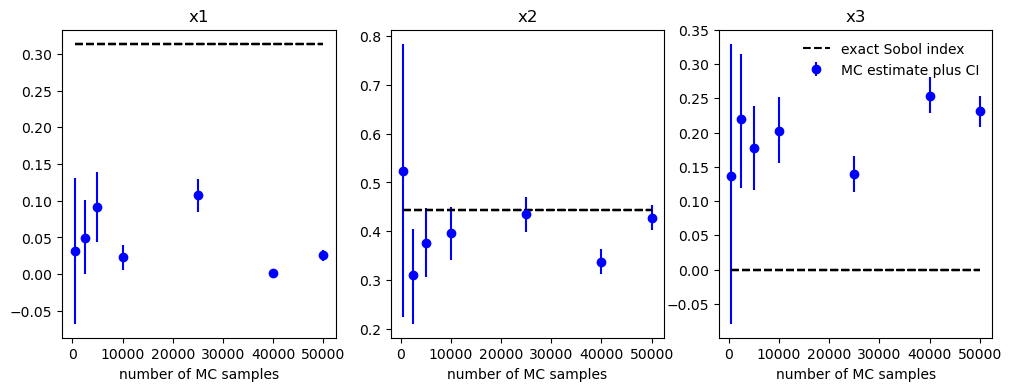

In [10]:
# plot the Sobol indices with bootstrap error bars versus the exact values of the (first-order) Sobol indices

sobol_first_exact = {'x1': exact['S1'], 'x2': exact['S2'], 'x3': exact['S3']}

N = [R[r]['number_of_samples'] for r in list(R.keys())]

fig = plt.figure(figsize=[12,4])

for idx, x in enumerate(sobol_first_exact.keys()):
    ax = fig.add_subplot(1, d, idx + 1, xlabel='number of MC samples', title=x)
    for n in N:
        sobol = R[n]['results'].sobols_first('Ishigami')[x]
        sobol_CI = R[n]['results']._get_sobols_first_conf('Ishigami', x)
        yerr = [sobol - sobol_CI[0], sobol_CI[1] - sobol]
        ax.errorbar(n, sobol, yerr=yerr, fmt='bo', label='MC estimate plus CI')
        ax.plot(N, sobol_first_exact[x] * np.ones(len(N)), '--k', label='exact Sobol index')

# avoid repeated legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), frameon=False)
plt.savefig('sobols_CI.png')

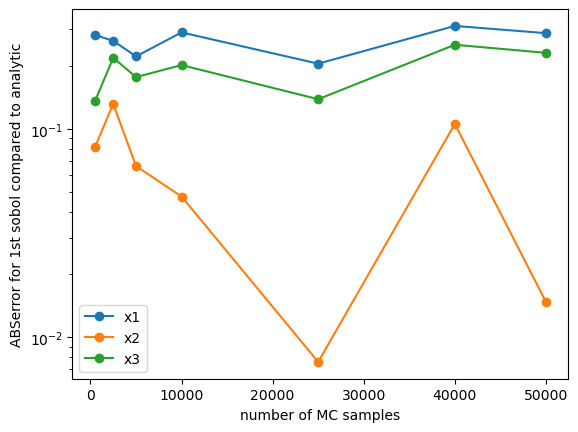

In [11]:
# plot the convergence of the first sobol to that of the highest order

sobol_first_exact = {'x1': exact['S1'], 'x2': exact['S2'], 'x3': exact['S3']}

N = [R[r]['number_of_samples'] for r in list(R.keys())]
plt.figure()
for v in list(R[N[0]]['results'].sobols_first('Ishigami').keys()):
    plt.semilogy([n for n in N],
                 [np.abs(R[n]['results'].sobols_first('Ishigami')[v] - sobol_first_exact[v]) for n in N],
                 'o-',
                 label=v)
plt.xlabel('number of MC samples')
plt.ylabel('ABSerror for 1st sobol compared to analytic')
plt.legend(loc=0)